In [1]:
import torch
from torch.nn import CosineSimilarity
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
from functools import partial
from baukit import TraceDict
from einops import rearrange, einsum
from collections import defaultdict
import matplotlib.pyplot as plt
from plotly_utils import imshow, scatter
from tqdm import tqdm

import pysvelte
import analysis_utils
from counterfactual_datasets.entity_tracking import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(10)

/home/local_nikhil/.conda/envs/anima/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
print("Model Loading...")
path = "./llama_7b/"
tokenizer = AutoTokenizer.from_pretrained(path)
model = AutoModelForCausalLM.from_pretrained(path).to(device)
tokenizer.pad_token_id = tokenizer.eos_token_id

Model Loading...


Loading checkpoint shards: 100%|██████████| 3/3 [00:09<00:00,  3.11s/it]


## Loading Data

In [3]:
raw_data = box_index_aligner_examples(
    tokenizer,
    num_samples=60,
    data_file="./box_datasets/no_instructions/original/3/train.jsonl",
    # object_file="./box_datasets/objects_with_bnc_frequency.csv",
    architecture="LLaMAForCausalLM",
    num_ents_or_ops=3,
    few_shot=False,
    alt_examples=False,
)

In [4]:
base_tokens = raw_data[0]
base_last_token_indices = raw_data[1]
source_tokens = raw_data[2]
source_last_token_indices = raw_data[3]
correct_answer_token = raw_data[4]
incorrect_answer_token = raw_data[6]

base_tokens = torch.tensor(base_tokens).to(device)
source_tokens = torch.tensor(source_tokens).to(device)

In [5]:
for i in range(-6, -1):
    print(tokenizer.decode(raw_data[0][i][: raw_data[1][i] + 1]))
    print(tokenizer.decode(raw_data[2][i][: raw_data[3][i] + 1]))
    print(tokenizer.decode(raw_data[4][i][raw_data[1][i]]))
    print()

 Box 0 contains flower, Box 1 contains nothing, Box 2 contains nothing. Box 0 contains
 Box 8 contains granite, Box 7 contains nothing, Box 4 contains GPU. Box 7 contains
 flower

 Box 0 contains flower, Box 1 contains nothing, Box 2 contains nothing. Box 1 contains
 Box 7 contains sucklet, Box 3 contains nothing, Box 9 contains biscotti. Box 9 contains
 nothing

 Box 0 contains flower, Box 1 contains nothing, Box 2 contains nothing. Box 2 contains
 Box 7 contains frappuccino, Box 8 contains nothing, Box 9 contains string. Box 7 contains
 nothing

 Box 0 contains cash, Box 1 contains furminator, Box 2 contains nothing. Box 0 contains
 Box 5 contains nothing, Box 3 contains nothing, Box 4 contains sheet. Box 3 contains
 c

 Box 0 contains cash, Box 1 contains furminator, Box 2 contains nothing. Box 1 contains
 Box 5 contains nothing, Box 6 contains leek, Box 7 contains adhesive. Box 7 contains
 fur



## Direct Logit Attribution for Object Fetcher Heads

In [45]:
hook_points = [
    f"model.layers.{layer}.self_attn.o_proj" for layer in range(model.config.num_hidden_layers)
]

with torch.no_grad():
    with TraceDict(
        model,
        hook_points,
        retain_input=True,
    ) as cache:
        _ = model(base_tokens)

In [48]:
batch_size = base_tokens.size(0)
d_head = model.config.hidden_size // model.config.num_attention_heads

direct_logit_attr = torch.zeros(
    model.config.num_attention_heads, model.config.num_attention_heads
).to(device)

with torch.no_grad():
    for layer in tqdm(range(model.config.num_hidden_layers)):
        for head in range(model.config.num_attention_heads):
            hook_point = f"model.layers.{layer}.self_attn.o_proj"
            all_head_out = cache[hook_point].input
            decoder = torch.nn.Sequential(
                model.model.layers[layer].self_attn.o_proj,
                model.model.norm,
                model.lm_head,
            )
            start = head * d_head
            end = (head + 1) * d_head

            for bi in range(batch_size):
                head_output = all_head_out[bi, base_last_token_indices[bi], start:end]
                head_output = torch.concat(
                    (
                        torch.zeros(head * d_head).to(head_output.device),
                        head_output,
                        torch.zeros((model.config.num_attention_heads - head - 1) * d_head).to(
                            head_output.device
                        ),
                    ),
                    dim=0,
                )
                head_unembed = decoder(head_output)
                correct_object = correct_answer_token[bi][base_last_token_indices[bi]]
                incorrect_objects = incorrect_answer_token[bi]
                direct_logit_attr[layer, head] += (
                    head_unembed[correct_object]
                    - head_unembed[incorrect_objects[0]]
                    - head_unembed[incorrect_objects[1]]
                )

            direct_logit_attr[layer, head] /= batch_size

torch.cuda.empty_cache()

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:55<00:00,  1.75s/it]


In [49]:
imshow(
    direct_logit_attr,
    yaxis_title="Layer",
    xaxis_title="Head",
)
# Softmax

In [8]:
imshow(
    direct_logit_attr,
    yaxis_title="Layer",
    xaxis_title="Head",
)
# Softmax

In [14]:
object_fetcher_heads = analysis_utils.compute_topk_components(direct_logit_attr, 10, largest=True)
print(object_fetcher_heads)

[[23, 15], [18, 24], [26, 16], [19, 16], [21, 29], [28, 17], [16, 13], [21, 3], [20, 27], [28, 30]]


## Logit Value Vs. Attention Score

In [8]:
# Attention to query box token

previous_query_box_attn_scores = defaultdict(list)

for layer in range(model.config.num_hidden_layers):
    attn_scores = analysis_utils.get_attn_scores(model, base_tokens, layer)

    for head in range(model.config.num_attention_heads):
        for bi in range(base_tokens.size(0)):
            query_box_token = base_tokens[bi][base_last_token_indices[bi] - 1]
            query_box_prev_pos = [
                i
                for i, token in enumerate(base_tokens[bi][: base_last_token_indices[bi] - 2])
                if token == query_box_token
            ]

            previous_query_box_attn_scores[(layer, head)].append(
                attn_scores[bi, head, base_last_token_indices[bi] - 1, query_box_prev_pos].item()
            )

In [13]:
# Attention to objects in the context

correct_object_attn_scores = defaultdict(list)
incorrect_object_1_attn_scores = defaultdict(list)
incorrect_object_2_attn_scores = defaultdict(list)

for layer in range(model.config.num_hidden_layers):
    attn_scores = analysis_utils.get_attn_scores(model, base_tokens, layer)

    for head in range(model.config.num_attention_heads):
        for bi in range(base_tokens.size(0)):
            query_box = int(
                tokenizer.decode(base_tokens[bi][base_last_token_indices[bi] - 1]).strip()
            )
            comma_pos = [pos for pos, token in enumerate(base_tokens[bi]) if token == 29892]
            comma_pos.insert(0, 0)
            correct_object_pos = comma_pos[query_box] + 5
            incorrect_objects_pos = []
            for box_ind, pos in enumerate(comma_pos):
                if box_ind != query_box:
                    incorrect_objects_pos.append(comma_pos[box_ind] + 5)

            correct_object_attn_scores[(layer, head)].append(
                attn_scores[bi, head, base_last_token_indices[bi], correct_object_pos].item()
            )
            incorrect_object_1_attn_scores[(layer, head)].append(
                attn_scores[bi, head, base_last_token_indices[bi], incorrect_objects_pos[0]].item()
            )
            incorrect_object_2_attn_scores[(layer, head)].append(
                attn_scores[bi, head, base_last_token_indices[bi], incorrect_objects_pos[1]].item()
            )

In [21]:
hook_point = [
    f"model.layers.{layer}.self_attn.o_proj" for layer in range(model.config.num_hidden_layers)
]
with torch.no_grad():
    with TraceDict(
        model,
        hook_point,
        retain_input=True,
    ) as cache:
        _ = model(base_tokens)

# %%
# Computing the logit value of correct object written by object fetcher heads
correct_object_direct_logit = defaultdict(list)
incorrect_object_1_direct_logit = defaultdict(list)
incorrect_object_2_direct_logit = defaultdict(list)

for layer in tqdm(range(model.config.num_hidden_layers)):
    for head in range(model.config.num_attention_heads):
        hook_point = f"model.layers.{layer}.self_attn.o_proj"

        all_head_out = cache[hook_point].input
        batch_size = base_tokens.size(0)
        d_head = model.config.hidden_size // model.config.num_attention_heads

        decoder = torch.nn.Sequential(
            model.model.layers[layer].self_attn.o_proj,
            model.model.norm,
            model.lm_head,
        )

        start = head * d_head
        end = (head + 1) * d_head

        for bi in range(batch_size):
            head_output = all_head_out[bi, base_last_token_indices[bi], start:end]
            head_output = torch.concat(
                (
                    torch.zeros(head * d_head).to(head_output.device),
                    head_output,
                    torch.zeros((model.config.num_attention_heads - head - 1) * d_head).to(
                        head_output.device
                    ),
                ),
                dim=0,
            )
            head_unembed = decoder(head_output)
            correct_object = correct_answer_token[bi][base_last_token_indices[bi]]

            correct_object_direct_logit[(layer, head)].append(head_unembed[correct_object].item())
            incorrect_object_1_direct_logit[(layer, head)].append(
                head_unembed[incorrect_answer_token[bi][0]].item()
            )
            incorrect_object_2_direct_logit[(layer, head)].append(
                head_unembed[incorrect_answer_token[bi][1]].item()
            )

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [01:00<00:00,  1.88s/it]


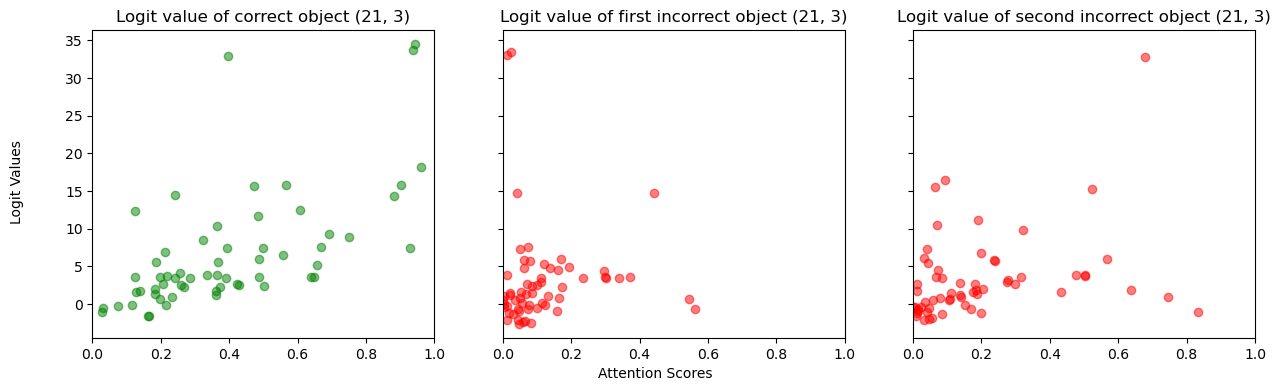

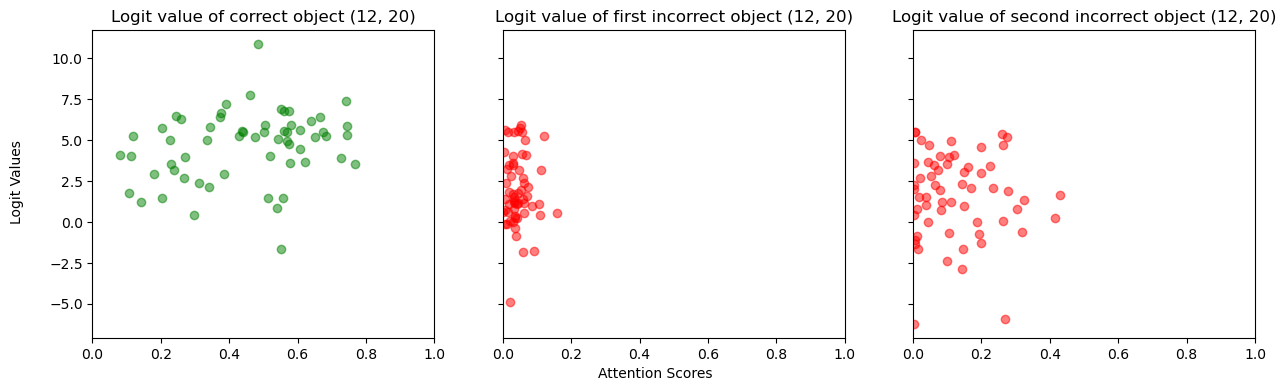

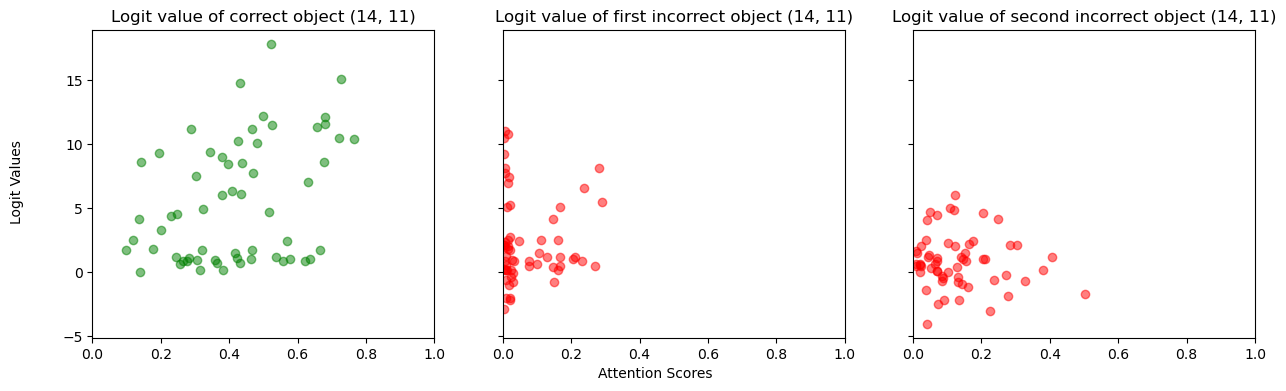

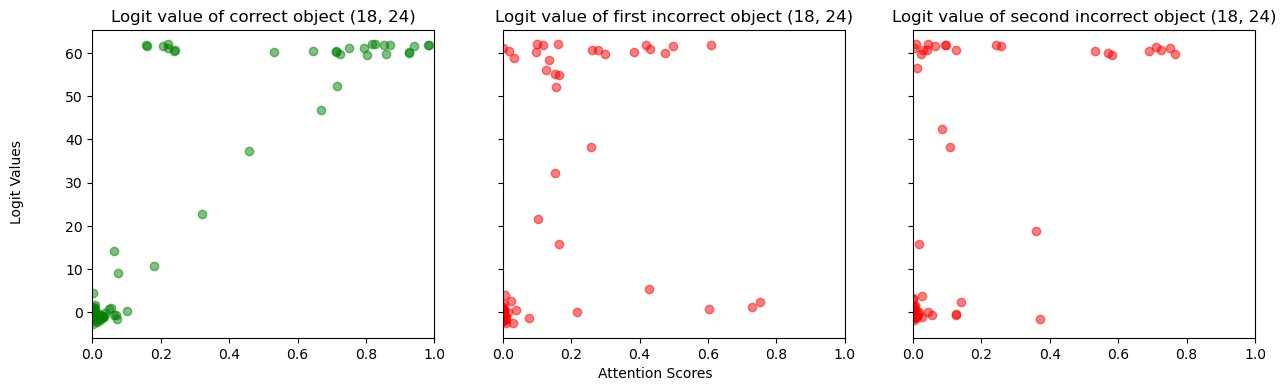

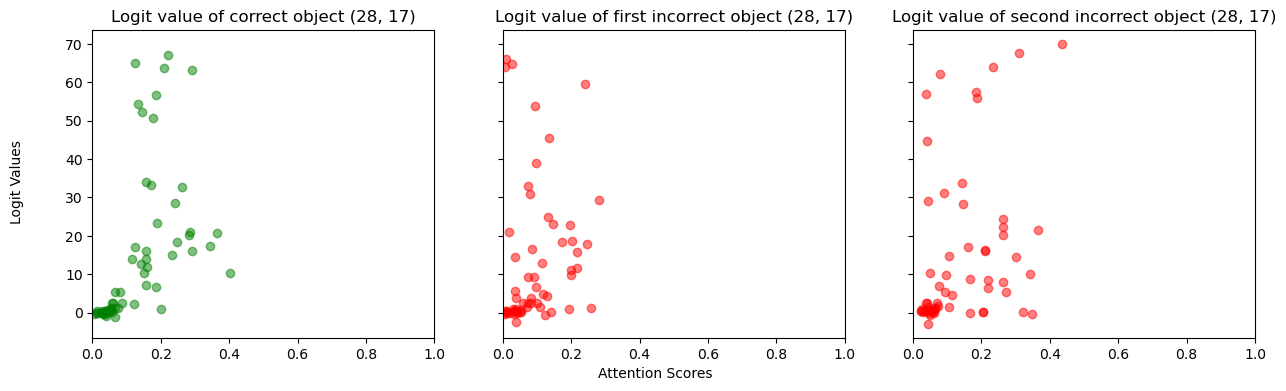

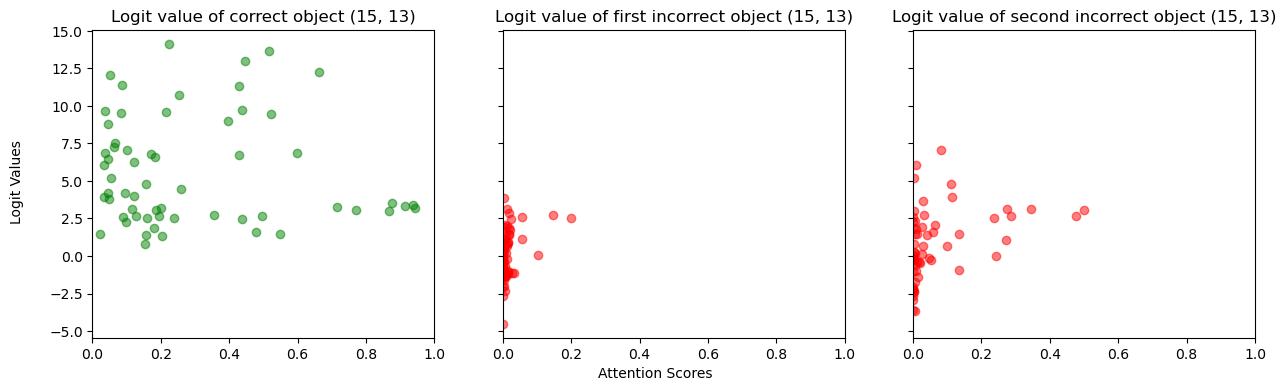

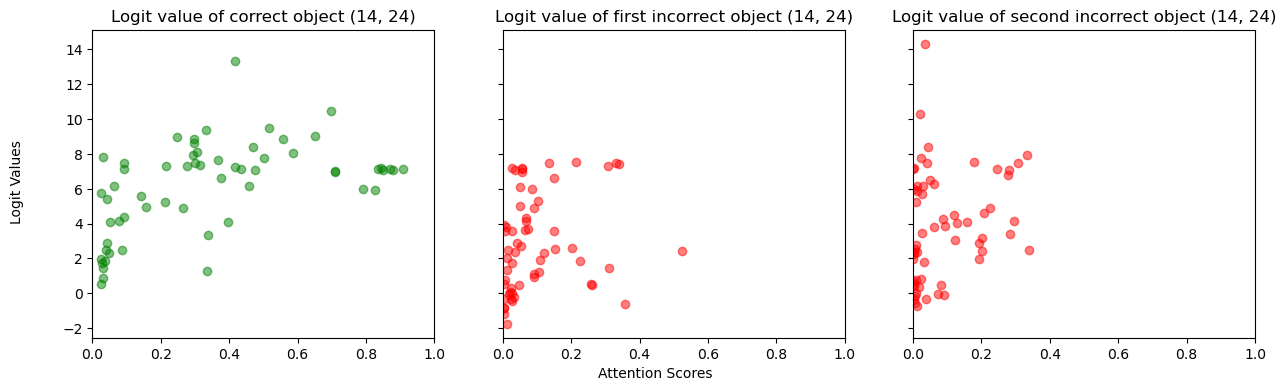

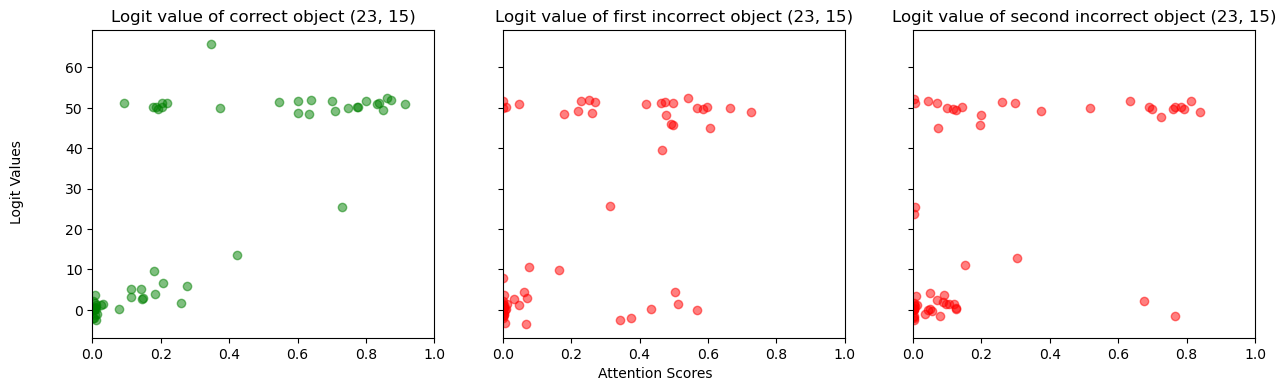

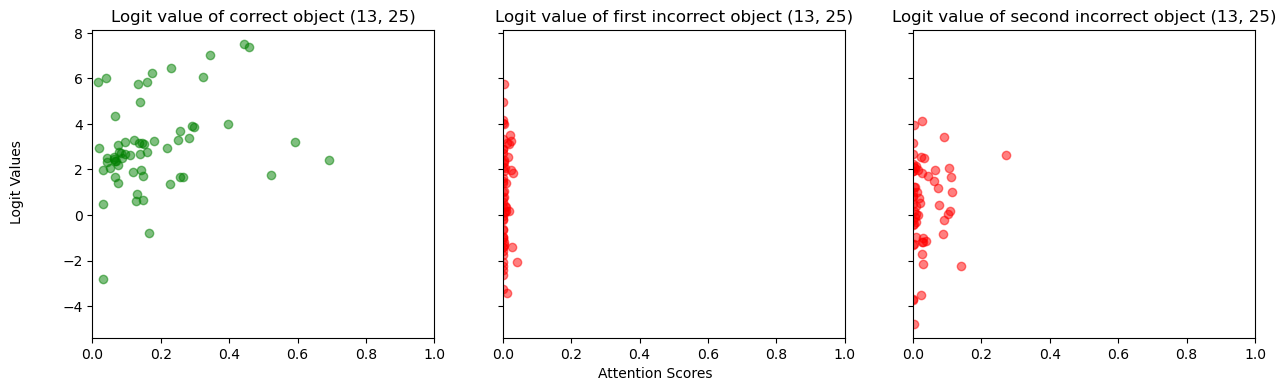

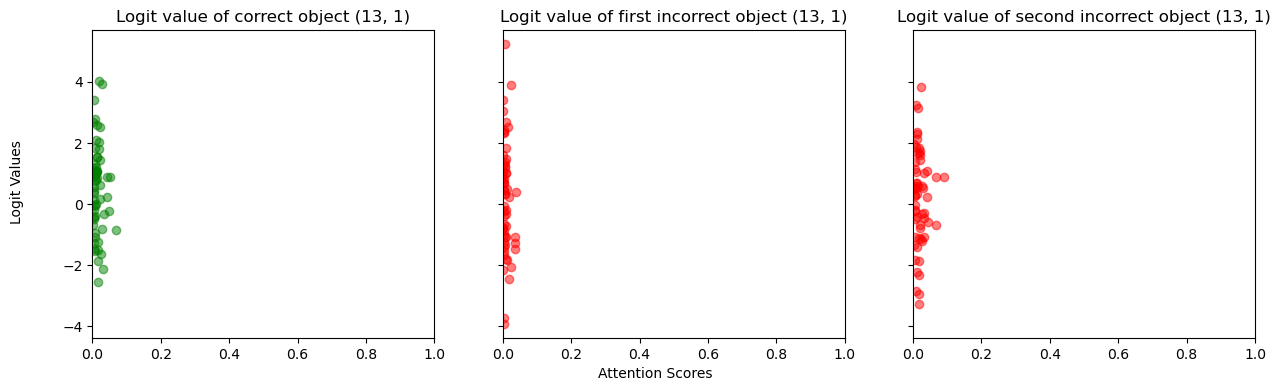

In [22]:
for layer, head in heads_influencing_final_logit:
    fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

    ax[0].scatter(
        correct_object_attn_scores[(layer, head)],
        correct_object_direct_logit[(layer, head)],
        color="green",
        alpha=0.5,
    )
    ax[1].scatter(
        incorrect_object_1_attn_scores[(layer, head)],
        incorrect_object_1_direct_logit[(layer, head)],
        color="red",
        alpha=0.5,
    )
    ax[2].scatter(
        incorrect_object_2_attn_scores[(layer, head)],
        incorrect_object_2_direct_logit[(layer, head)],
        color="red",
        alpha=0.5,
    )

    fig.text(0.5, 0.01, "Attention Scores", ha="center")
    fig.text(0.07, 0.5, "Logit Values", va="center", rotation="vertical")

    ax[0].set_xlim(0, 1)
    # ax[0].set_ylim(-1, 10)

    ax[0].set_title("Logit value of correct object ({}, {})".format(layer, head))
    ax[1].set_title("Logit value of first incorrect object ({}, {})".format(layer, head))
    ax[2].set_title("Logit value of second incorrect object ({}, {})".format(layer, head))

    plt.show()

## Implementing Path Patching

In [10]:
hook_points = [
    f"model.layers.{layer}.self_attn.o_proj" for layer in range(model.config.num_hidden_layers)
]

# hook_points += [f"model.layers.{layer}.mlp" for layer in range(model.config.num_hidden_layers)]

with torch.no_grad():
    # Step 1
    with TraceDict(
        model,
        hook_points,
        retain_input=True,
    ) as clean_cache:
        _ = model(base_tokens)

    with TraceDict(
        model,
        hook_points,
        retain_input=True,
    ) as corrupt_cache:
        _ = model(source_tokens)

In [11]:
def patching_heads(
    inputs,
    output,
    layer,
    sender_layer,
    sender_head,
    clean_last_token_indices,
    corrupt_last_token_indices,
    rel_pos,
):
    input = inputs[0]
    batch_size = input.size(0)

    if "o_proj" in layer:
        input = rearrange(
            input,
            "batch seq_len (n_heads d_head) -> batch seq_len n_heads d_head",
            n_heads=model.config.num_attention_heads,
        )
        clean_head_outputs = rearrange(
            clean_cache[layer].input,
            "batch seq_len (n_heads d_head) -> batch seq_len n_heads d_head",
            n_heads=model.config.num_attention_heads,
        )
        corrupt_head_outputs = rearrange(
            corrupt_cache[layer].input,
            "batch seq_len (n_heads d_head) -> batch seq_len n_heads d_head",
            n_heads=model.config.num_attention_heads,
        )

        layer = int(layer.split(".")[2])
        if sender_layer == layer:
            for bi in range(batch_size):
                for pos in range(rel_pos + 1):
                    for head_ind in range(model.config.num_attention_heads):
                        if head_ind == sender_head and pos == rel_pos:
                            input[
                                bi, clean_last_token_indices[bi] - pos, sender_head
                            ] = corrupt_head_outputs[
                                bi, corrupt_last_token_indices[bi] - pos, sender_head
                            ]

                        else:
                            input[
                                bi, clean_last_token_indices[bi] - pos, head_ind
                            ] = clean_head_outputs[bi, clean_last_token_indices[bi] - pos, head_ind]

        else:
            for bi in range(batch_size):
                for pos in range(rel_pos + 1):
                    input[bi, clean_last_token_indices[bi] - pos] = clean_head_outputs[
                        bi, clean_last_token_indices[bi] - pos
                    ]

        input = rearrange(
            input,
            "batch seq_len n_heads d_head -> batch seq_len (n_heads d_head)",
            n_heads=model.config.num_attention_heads,
        )

        w_o = model.model.layers[layer].self_attn.o_proj.weight
        output = einsum(
            input, w_o, "batch seq_len hidden_size, d_model hidden_size -> batch seq_len d_model"
        )

    # elif "mlp" in layer:
    #     for bi in range(batch_size):
    #         output[bi, clean_last_token_indices[bi]] = clean_cache[bi, clean_last_token_indices[bi]]

    return output

In [12]:
def patching_receiver_heads(
    output, layer, patched_cache, receiver_heads, clean_last_token_indices, rel_pos
):
    batch_size = output.size(0)
    receiver_heads_in_curr_layer = [h for l, h in receiver_heads if l == int(layer.split(".")[2])]

    output = rearrange(
        output,
        "batch seq_len (n_heads d_head) -> batch seq_len n_heads d_head",
        n_heads=model.config.num_attention_heads,
    )
    patched_head_outputs = rearrange(
        patched_cache[layer].output,
        "batch seq_len (n_heads d_head) -> batch seq_len n_heads d_head",
        n_heads=model.config.num_attention_heads,
    )

    # Patch in the output of the receiver heads from patched run
    for receiver_head in receiver_heads_in_curr_layer:
        for bi in range(batch_size):
            output[
                bi, clean_last_token_indices[bi] - rel_pos, receiver_head
            ] = patched_head_outputs[bi, clean_last_token_indices[bi] - rel_pos, receiver_head]

    output = rearrange(
        output,
        "batch seq_len n_heads d_head -> batch seq_len (n_heads d_head)",
        n_heads=model.config.num_attention_heads,
    )
    # w = model.state_dict()[f"{layer}.weight"]
    # output = einsum(
    #     input, w, "batch seq_len hidden_size, d_model hidden_size -> batch seq_len d_model"
    # )

    return output

In [428]:
receiver_layers = list(
    set([f"model.layers.{layer}.self_attn.k_proj" for layer, _ in query_box_attender_heads[:1]])
)

receiver_heads = [[layer, head] for layer, head in query_box_attender_heads[:1]]

print(receiver_layers)
print(receiver_heads)

['model.layers.11.self_attn.k_proj']
[[11, 23]]


In [14]:
path_patching_logits = torch.zeros(
    model.config.num_hidden_layers, model.config.num_attention_heads
).to(device)
batch_size = base_tokens.size(0)
apply_softmax = torch.nn.Softmax(dim=-1)

for layer in tqdm(range(model.config.num_hidden_layers)):
    for head in range(model.config.num_attention_heads):
        with torch.no_grad():
            # Step 2
            with TraceDict(
                model,
                hook_points + receiver_layers,
                retain_input=True,
                edit_output=partial(
                    patching_heads,
                    sender_layer=layer,
                    sender_head=head,
                    clean_last_token_indices=base_last_token_indices,
                    corrupt_last_token_indices=source_last_token_indices,
                    rel_pos=0,
                ),
            ) as patched_cache:
                _ = model(base_tokens)

            # Step 3
            with TraceDict(
                model,
                receiver_layers,
                retain_input=True,
                edit_output=partial(
                    patching_receiver_heads,
                    patched_cache=patched_cache,
                    receiver_heads=receiver_heads,
                    clean_last_token_indices=base_last_token_indices,
                    rel_pos=1,
                ),
            ) as _:
                patched_out = model(base_tokens)

            for bi in range(batch_size):
                logits = apply_softmax(patched_out.logits[bi, base_last_token_indices[bi]])
                path_patching_logits[layer, head] += (
                    logits[correct_answer_token[bi][base_last_token_indices[bi]]]
                ).item()

            path_patching_logits[layer, head] = path_patching_logits[layer, head] / batch_size

torch.cuda.empty_cache()

100%|██████████| 32/32 [12:26<00:00, 23.33s/it]


In [16]:
imshow(
    (path_patching_logits - torch.mean(path_patching_logits)) / torch.std(path_patching_logits),
    title="Heads affecting final logits",
    yaxis_title="Layer",
    xaxis_title="Head",
)

In [17]:
previous_token_heads = analysis_utils.compute_topk_components(
    path_patching_logits, 10, largest=False
)

print(previous_token_heads)

[[24, 7], [17, 26], [21, 3], [23, 5], [18, 3], [28, 17], [19, 8], [23, 24], [15, 5], [21, 4]]


## Circuit Analysis

In [11]:
path = "./path patching experiments/direct_output_affecting_heads.pt"
logit_values = torch.load(path)

imshow(
    (logit_values - torch.mean(logit_values)) / torch.std(logit_values),
    title="Heads influencing final logit",
    yaxis_title="Layer",
    xaxis_title="Head",
)

heads_influencing_final_logit = analysis_utils.compute_topk_components(
    torch.load(path), k=10, largest=False
)
print(f"Head influencing final logit: {heads_influencing_final_logit}")

Head influencing final logit: [[21, 3], [12, 20], [14, 11], [18, 24], [28, 17], [15, 13], [14, 24], [23, 15], [13, 25], [13, 1]]


In [245]:
# There are two sets of heads that are directly influencing the final logit:
# 1. Heads in layer after layer 15: These heads are attending to the object token and writing object info in the final residual stream. Not necessary only attending to correct object, they seem to attend to all objects and bring in info of incorrect tokens as well.
# 2. Heads in layer before layer 15: These heads are attending to the correct object token, but are not bringing in the object info. (Possibly bringing positional info of the correct object token).

# First set of heads (in layers > 15): They shouldn't be in K or V composition with previos heads as neither key or value vectors of these heads are being utilized due to their high attention to the correct object token. (I've tried computed heads via other composition and those heads do not seem to follow specific pattern or purpose).
# The following plot shows the heads that are in Q-composition with these heads. It turns out that those are basically the second set of heads that are influencing the final logit. These set of heads are attending to correct object, but not bringing in object info.

path = "./path patching experiments/object_feeder_heads_layer_after_15_query_vector.pt"
logit_values = torch.load(path)

imshow(
    (logit_values - torch.mean(logit_values)) / torch.std(logit_values),
    title="Heads affecting query vector of object fetcher heads (layer > 15)",
    yaxis_title="Layer",
    xaxis_title="Head",
)

heads_influencing_object_value_fetcher_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=5, largest=False
)
print(
    f"Head influencing object info fetcher heads in layers > 15: {heads_influencing_object_value_fetcher_heads}"
)

Head influencing object info fetcher heads in layers > 15: [[12, 20], [14, 11], [15, 13], [13, 25], [14, 27]]


In [246]:
# Next question: Which heads influence the heads that are the attending to the correct object token?
# These heads cannot be in K or V composition with other heads due to the same reason as above, i.e. their key and value vectors almost remain unused, hence those composition would be meaningless.

# The following plot shows the heads that are in Q-composition with the heads that are attending to the correct object token.
# Primarily a single head (11, 23) in layer 11 is doing all heavy lifting. These heads are primparily attending to the query box token. However, they are not writing the box number info in the final residual stream (based on scatter plot results).

path = "./path patching experiments/object_feeder_heads_layer_before_15_query_vectors.pt"
logit_values = torch.load(path)

imshow(
    (logit_values - torch.mean(logit_values)) / torch.std(logit_values),
    title="Heads affecting query vector of correct object locator heads",
    yaxis_title="Layer",
    xaxis_title="Head",
)

query_box_attender_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=4, largest=False
)
print(f"Head influencing correct object locator heads: {query_box_attender_heads}")

Head influencing correct object locator heads: [[11, 23], [14, 27], [13, 1], [10, 6]]


In [480]:
# So, the next question is what information it might be bring in from the query box token?
# Since the head (11, 23) at final position is attending heavily to the (11, 23) head at the query box token, we need analyse what information is stored in the value vector of (11, 23) head at the query box token, which is getting passes on to the final token residual stream. To answer that question, I identified the heads that are in V-composition with (11, 23) head at the query box position.

# The following plot shows those heads
path = "./path patching experiments/new_previous_box_token_attender_heads (value).pt"
logit_values = torch.load(path)

imshow(
    (logit_values - torch.mean(logit_values)) / torch.std(logit_values),
    title="Heads affecting value vector of query box attender head at query box token position",
    yaxis_title="Layer",
    xaxis_title="Head",
)

query_box_attender_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=10, largest=False
)
print(f"Head influencing value vector of query box attender heads: {query_box_attender_heads}")

Head influencing value vector of query box attender heads: [[10, 3], [9, 2], [8, 12], [7, 17], [6, 10], [8, 1], [4, 27], [10, 17], [9, 5], [9, 10]]


It turns out that some of these heads are duplicate token identifier, while a few others are induction heads, i.e. they are attending to the previous occurance of the query box token. However, they are not bringing in box index value information (based on scatter plot results). Most probably they are bringing/computing the positional information of the previous query box token. And that information is being used to compute the value vector of head (11, 23) at the query box token, which is being passed onto the final token residual stream.

In [482]:
# Head (11, 23) also seem to be in K-composition with similar set of heads, as shown in the following plot.
# My hypothesis is that the information brought in by these heads are being used to compute the key vector (11, 23) at the query box position, and that's why (11, 23) heads at the final position is attending heavily onto it.

path = "./path patching experiments/new_previous_box_token_attender_heads (key).pt"
logit_values = torch.load(path)

imshow(
    (logit_values - torch.mean(logit_values)) / torch.std(logit_values),
    title="Heads affecting key vector of query box attender head at query box token position",
    yaxis_title="Layer",
    xaxis_title="Head",
)

query_box_attender_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=10, largest=False
)
print(f"Head influencing key vector of query box attender heads: {query_box_attender_heads}")

Head influencing key vector of query box attender heads: [[10, 3], [9, 7], [9, 2], [9, 21], [8, 12], [10, 15], [9, 10], [8, 26], [9, 24], [9, 0]]


## Visualizing Head Attention

In [475]:
layer = 8
attn_scores = analysis_utils.get_attn_scores(model, base_tokens, layer)

In [478]:
index = 2
print(f"Layer: {layer}, Bi: {index}")
pysvelte.AttentionMulti(
    tokens=[tokenizer.decode(token) for token in base_tokens[index].cpu().tolist()],
    attention=attn_scores[index].permute(1, 2, 0).cpu(),
).show()

Layer: 8, Bi: 2
